In [230]:
import sys
print(sys.executable)
#should be AI project


C:\Users\Johanna\anaconda3\envs\AI_project\python.exe


In [241]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from functools import reduce
from datetime import time
import seaborn as sns


In [3]:
df_2_full = pd.read_parquet("data/processed/df_2_full_v2.parquet")
df_2_full.head()

##otherwise
#df_2_full = pd.read_csv("data/processed/df_2_full.csv",sep=";", parse_dates=['Datetime'])
#df_2_full['Time_only'] = df_2_full['Datetime'].dt.time
#df_2_full['Date_only']=df_2_full['Datetime'].dt.date##
#df_2_full.head()




,Datetime,DP_ID,PORTAL,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Time_only,Date_only,PORTAL_clean,SPEED_MS_AVG_filled,FLOW_filled
0,2021-06-01 04:00:00,539,"E4S 56,160",240,48,16,8,4,19.64,9.0,04:00:00,2021-06-01,56160,19.64,9.0
1,2021-06-01 04:00:00,536,"E4S 56,160",240,48,16,8,4,28.35,2.0,04:00:00,2021-06-01,56160,28.35,2.0
2,2021-06-01 04:00:00,751,"E4S 55,620",240,48,16,8,4,21.53,19.0,04:00:00,2021-06-01,55620,21.53,19.0
3,2021-06-01 04:00:00,740,"E4S 56,160",240,48,16,8,4,21.99,17.0,04:00:00,2021-06-01,56160,21.99,17.0
4,2021-06-01 04:00:00,1254,"E4S 55,620",240,48,16,8,4,24.53,4.0,04:00:00,2021-06-01,55620,24.53,4.0


In [231]:
df_all=pd.read_parquet("data/processed/df_all.parquet")
df_all.head()
##otherwise
#df_all = pd.read_csv("data/processed/df_all.csv",sep=";", parse_dates=['Datetime'])
#df_all.head()


,Datetime,SENSOR_539_FLOW,SENSOR_539_SPEED,SENSOR_536_FLOW,SENSOR_536_SPEED,SENSOR_751_FLOW,SENSOR_751_SPEED,SENSOR_740_FLOW,SENSOR_740_SPEED,SENSOR_1254_FLOW,SENSOR_1254_SPEED,SENSOR_1076_FLOW,SENSOR_1076_SPEED
0,2021-06-01 04:00:00,9.0,19.64,2.0,28.35,19.0,21.53,17.0,21.99,4.0,24.53,6.0,20.27
1,2021-06-01 04:01:00,11.0,22.04,7.0,27.03,13.0,22.26,15.0,24.16,1.0,27.20,12.0,21.14
2,2021-06-01 04:02:00,12.0,21.40,10.0,24.17,18.0,20.97,20.0,23.27,7.0,22.80,13.0,21.72
3,2021-06-01 04:03:00,4.0,20.78,13.0,24.63,17.0,22.67,13.0,23.78,7.0,23.21,10.0,22.33
4,2021-06-01 04:04:00,7.0,22.61,7.0,27.67,14.0,22.13,18.0,23.11,8.0,25.69,7.0,22.19


Variables

In [4]:
target_sensor = 1076
same_portal="55620"
neighbour_portal = "56160"

same_portal_sensors = df_2_full[df_2_full['PORTAL_clean'] == same_portal]['DP_ID'].unique()
same_sensors = [s for s in same_portal_sensors if s != target_sensor]


neighbour_sensors = df_2_full[df_2_full['PORTAL_clean'] == neighbour_portal]['DP_ID'].unique()
all_sensors=df_2_full['DP_ID'].unique()
except_target_sensors = [s for s in all_sensors if s != target_sensor]




In [233]:
flow_features_same_nl = [
    f'SENSOR_{sensor}_FLOW'
    for sensor in same_sensors

]
flow_features_neighbour_nl = [
    f'SENSOR_{sensor}_FLOW'
    for sensor in neighbour_sensors

]
speed_features_same_nl = [
    f'SENSOR_{sensor}_SPEED'
    for sensor in same_sensors
]
speed_features_neighbour_nl = [
    f'SENSOR_{sensor}_SPEED'
    for sensor in neighbour_sensors
]

In [234]:
flow_features_same = [
    f'SENSOR_{sensor}_FLOW_lag_{i+1}'
    for sensor in same_sensors
    for i in range(nlags)
]
flow_features_neighbour = [
    f'SENSOR_{sensor}_FLOW_lag_{i+1}'
    for sensor in neighbour_sensors
    for i in range(nlags)
]
speed_features_same = [
    f'SENSOR_{sensor}_SPEED_lag_{i+1}'
    for sensor in same_sensors
    for i in range(nlags)
]
speed_features_neighbour = [
    f'SENSOR_{sensor}_SPEED_lag_{i+1}'
    for sensor in neighbour_sensors
    for i in range(nlags)
]

In [96]:
portal_to_sensors = df_2_full.groupby("PORTAL_clean")["DP_ID"].unique().to_dict()
print(portal_to_sensors)
sensor_to_portal = {}
for portal, sensor_list in portal_to_sensors.items():
    for sensor in sensor_list:
        sensor_to_portal[sensor] = portal

{'55620': array([ 751, 1254, 1076], dtype=int64), '56160': array([539, 536, 740], dtype=int64)}


Lag features

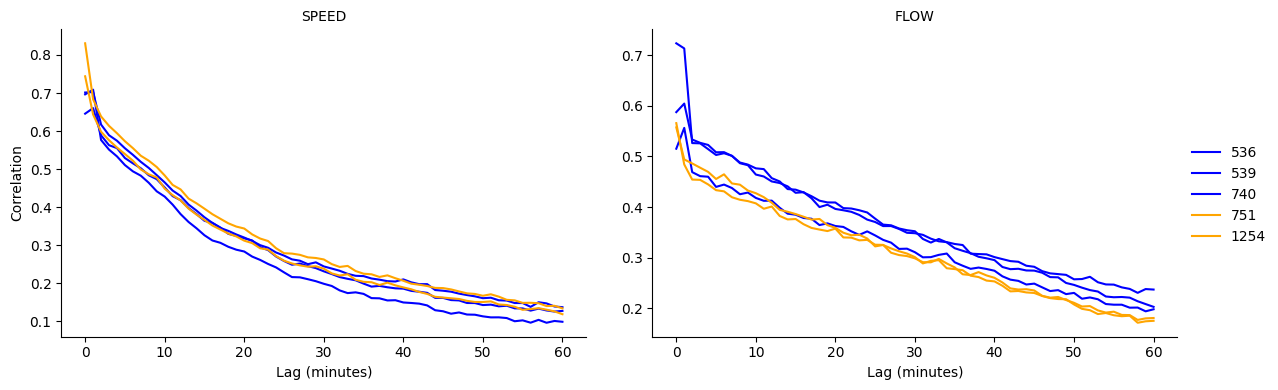

feature  sensor
SPEED    751       0.830716
         1254      0.744050
FLOW     539       0.723636
SPEED    539       0.708879
         740       0.702637
         536       0.660361
FLOW     740       0.604476
         1254      0.565824
         751       0.557476
         536       0.556442
Name: corr, dtype: float64


In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

features = ["SPEED", "FLOW"]
max_lag = 60

results = []

for feat in features:
    target_col = f"SENSOR_{target_sensor}_{feat}" #SENSOR_1076_FLOW
    for sensor in except_target_sensors:
        sensor_col = f"SENSOR_{sensor}_{feat}"
        for lag in range(max_lag + 1):
            corr = df_all_peak[target_col].corr(df_all_peak[sensor_col].shift(lag))
            results.append({
                "feature": feat,
                "sensor": sensor,
                "lag": lag,
                "corr": corr
            })

lag_corr_df = pd.DataFrame(results)



lag_corr_df["portal"] = lag_corr_df["sensor"].map(sensor_to_portal)
portal_colors = {
    "56160": "blue",
    "55620": "orange",
}



g = sns.FacetGrid(lag_corr_df, col="feature", sharey=False, height=4, aspect=1.5)

def portal_lineplot(data, **kwargs):
    for sensor, group in data.groupby("sensor"):
        portal = sensor_to_portal.get(sensor, "unknown")
        color = portal_colors.get(portal, "gray")
        kwargs_clean = {k: v for k, v in kwargs.items() if k != "color"}
        sns.lineplot(
            data=group,
            x="lag",
            y="corr",
            label=sensor,
            color=color,
            **kwargs_clean
        )

g.map_dataframe(portal_lineplot)
g.add_legend()
g.set_axis_labels("Lag (minutes)", "Correlation")
g.set_titles("{col_name}")
plt.savefig("Plots/Correlation_lag_flow_speed_peak.eps")
plt.savefig("Plots/Correlation_lag_flow_speed_peak.png")
plt.show()




In [244]:
selected_lags = lag_corr_df[lag_corr_df["corr"] >= 0.7 * lag_corr_df.groupby(["feature", "sensor"])["corr"].transform("max")]
print(selected_lags)
print(selected_lags.groupby(["feature", "sensor"])["lag"].max())
print(selected_lags.groupby(["feature", "sensor"])["lag"].max().groupby(["feature"]).mean())


    feature  sensor  lag      corr portal
0     SPEED     539    0  0.696572  56160
1     SPEED     539    1  0.708879  56160
2     SPEED     539    2  0.576724  56160
3     SPEED     539    3  0.551420  56160
4     SPEED     539    4  0.533617  56160
..      ...     ...  ...       ...    ...
557    FLOW    1254    8  0.414330  55620
558    FLOW    1254    9  0.411669  55620
559    FLOW    1254   10  0.407242  55620
560    FLOW    1254   11  0.396553  55620
561    FLOW    1254   12  0.401022  55620

[101 rows x 5 columns]
feature  sensor
FLOW     536       13
         539        4
         740       16
         751       14
         1254      12
SPEED    536        9
         539        5
         740        8
         751        4
         1254       6
Name: lag, dtype: int64
feature
FLOW     11.8
SPEED     6.4
Name: lag, dtype: float64


In [119]:
#nlags=30
nlags=15

In [153]:
df_lagged_all = []
for sensor in except_target_sensors:
    df_sensor = df_lagged[df_lagged['DP_ID'] == sensor].copy()
    df_sensor = df_sensor.rename(columns={
        f'FLOW_filled_lag_{i+1}': f'SENSOR_{sensor}_FLOW_lag_{i+1}' for i in range(nlags)
    })
    df_sensor = df_sensor.rename(columns={
        f'SPEED_MS_AVG_filled_lag_{i+1}': f'SENSOR_{sensor}_SPEED_lag_{i+1}' for i in range(nlags)
    })
    df_sensor = df_sensor[['Datetime'] + [f'SENSOR_{sensor}_FLOW_lag_{i+1}' for i in range(nlags)]+[f'SENSOR_{sensor}_SPEED_lag_{i+1}' for i in range(nlags)]]
    df_lagged_all.append(df_sensor)
df_lagged_all = reduce(lambda l, r: pd.merge(l, r, on='Datetime', how='inner'), df_lagged_all)
df_lagged_all=df_lagged_all.merge(df_2_full[df_2_full['DP_ID']==target_sensor][["Datetime","FLOW_filled","SPEED_MS_AVG_filled"]], on=['Datetime'], how='left')
df_lagged_all.head()
print(df_lagged_all.columns)

Index(['Datetime', 'SENSOR_539_FLOW_lag_1', 'SENSOR_539_FLOW_lag_2',
       'SENSOR_539_FLOW_lag_3', 'SENSOR_539_FLOW_lag_4',
       'SENSOR_539_FLOW_lag_5', 'SENSOR_539_FLOW_lag_6',
       'SENSOR_539_FLOW_lag_7', 'SENSOR_539_FLOW_lag_8',
       'SENSOR_539_FLOW_lag_9',
       ...
       'SENSOR_1254_SPEED_lag_8', 'SENSOR_1254_SPEED_lag_9',
       'SENSOR_1254_SPEED_lag_10', 'SENSOR_1254_SPEED_lag_11',
       'SENSOR_1254_SPEED_lag_12', 'SENSOR_1254_SPEED_lag_13',
       'SENSOR_1254_SPEED_lag_14', 'SENSOR_1254_SPEED_lag_15', 'FLOW_filled',
       'SPEED_MS_AVG_filled'],
      dtype='object', length=153)


In [151]:
def build_lag_features(df, target_col, lags=nlags):
    df = df.sort_values('Datetime')
    for i in range(1, lags + 1):
        df[f'{target_col}_lag_{i}'] = df.groupby('DP_ID')[target_col].shift(i)
    return df


In [152]:
df_lagged = build_lag_features(df_2_full, 'FLOW_filled', lags=nlags)
df_lagged = build_lag_features(df_lagged,"SPEED_MS_AVG_filled", lags=nlags)
df_lagged = df_lagged[df_lagged[f'FLOW_filled_lag_{nlags}'].notna()]

print(df_lagged.isna().sum())
print(df_lagged.shape)


Datetime                          0
DP_ID                             0
PORTAL                            0
Interval_1                        0
Interval_5                        0
Interval_15                       0
Interval_30                       0
Interval_60                       0
SPEED_MS_AVG                  22876
FLOW                          22876
Time_only                         0
Date_only                         0
PORTAL_clean                      0
SPEED_MS_AVG_filled               0
FLOW_filled                       0
FLOW_future_sum                  84
SPEED_future_mean                84
FLOW_filled_lag_1                 0
FLOW_filled_lag_2                 0
FLOW_filled_lag_3                 0
FLOW_filled_lag_4                 0
FLOW_filled_lag_5                 0
FLOW_filled_lag_6                 0
FLOW_filled_lag_7                 0
FLOW_filled_lag_8                 0
FLOW_filled_lag_9                 0
FLOW_filled_lag_10                0
FLOW_filled_lag_11          

In [161]:
df_2_full['FLOW_future_sum'] = (
    df_2_full.groupby('DP_ID')['FLOW_filled']
    .rolling(15, min_periods=15)
    .sum()
    .shift(-14)  # damit die Summe bei t=07:02 die Werte von 07:02–07:16 enthält
    .reset_index(level=0, drop=True)
)
df_2_full['SPEED_future_mean'] = (
    df_2_full.groupby('DP_ID')['SPEED_MS_AVG_filled']
    .rolling(15, min_periods=15)
    .mean()
    .shift(-14)  # damit die Summe bei t=07:02 die Werte von 07:02–07:16 enthält
    .reset_index(level=0, drop=True)
)


df_lagged_all=df_lagged_all.merge(df_2_full[df_2_full['DP_ID']==target_sensor][["Datetime","FLOW_future_sum","SPEED_future_mean"]], on=['Datetime'], how='left')
print(df_lagged_all.shape)
df_lagged_all = df_lagged_all[df_lagged_all['Datetime'].dt.time <= time(9, 45)]
print(df_lagged_all.shape)

#print(df_lagged_all["Datetime"]dt.time.min(), df_lagged_all["Datetime"].dt.date.max())
df_lagged_all.head(20)
print(df_lagged_all.isna().sum())


(76156, 155)
(72991, 155)
Datetime                    0
SENSOR_539_FLOW_lag_1       0
SENSOR_539_FLOW_lag_2       0
SENSOR_539_FLOW_lag_3       0
SENSOR_539_FLOW_lag_4       0
                           ..
SENSOR_1254_SPEED_lag_15    0
FLOW_filled                 0
SPEED_MS_AVG_filled         0
FLOW_future_sum             0
SPEED_future_mean           0
Length: 155, dtype: int64


In [ ]:
#df_lagged_all.to_parquet("data/processed/df_lagged_all.parquet", index=False)
#df_lagged_all.to_parquet("data/processed/df_lagged_30_all.parquet", index=False)
#df_lagged_all_peak.to_parquet("data/processed/df_lagged_all_peak.parquet", index=False)

Train-Test-split

In [250]:
df_train_nl, df_test_nl = train_test_split(df_all, test_size=0.2, random_state=42)
df_test_nl_peak=df_test_nl.set_index("Datetime").between_time("07:30", "08:30").reset_index()

df_train, df_test = train_test_split(df_lagged_all, test_size=0.2, random_state=42)
df_test_peak=df_test.set_index("Datetime").between_time("07:30", "08:30").reset_index()


prediction same time

In [251]:
#same portal
model_flow = LinearRegression()
model_flow.fit(df_train_nl[flow_features_same_nl], df_train_nl[f'SENSOR_{target_sensor}_FLOW' ])

model_speed = LinearRegression()
model_speed.fit(df_train_nl[speed_features_same_nl], df_train_nl[f'SENSOR_{target_sensor}_SPEED' ])

# prediction
y_pred = model_flow.predict(df_test_nl[flow_features_same_nl])
y_test=df_test_nl[f'SENSOR_{target_sensor}_FLOW']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test_nl[speed_features_same_nl])
y_test=df_test_nl[f'SENSOR_{target_sensor}_SPEED']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Baseline Linear Regression (FLOW) -> RMSE: 3.992, MAE: 3.167, R2: 0.618
Baseline Linear Regression (SPEED) -> RMSE: 1.007, MAE: 0.732, R2: 0.723


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [253]:
#neighbour portal
model_flow = LinearRegression()
model_flow.fit(df_train_nl[flow_features_neighbour_nl], df_train_nl[f'SENSOR_{target_sensor}_FLOW' ])

model_speed = LinearRegression()
model_speed.fit(df_train_nl[speed_features_neighbour_nl], df_train_nl[f'SENSOR_{target_sensor}_SPEED' ])

# prediction
y_pred = model_flow.predict(df_test_nl[flow_features_neighbour_nl])
y_test=df_test_nl[f'SENSOR_{target_sensor}_FLOW']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test_nl[speed_features_neighbour_nl])
y_test=df_test_nl[f'SENSOR_{target_sensor}_SPEED']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Baseline Linear Regression (FLOW) -> RMSE: 3.349, MAE: 2.604, R2: 0.731
Baseline Linear Regression (SPEED) -> RMSE: 1.223, MAE: 0.808, R2: 0.591


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


predict current time based on the last 15 min

In [257]:
#saame portal


model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_same], df_train['FLOW_filled'])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_same], df_train['SPEED_MS_AVG_filled'])




# prediction
y_pred = model_flow.predict(df_test[flow_features_same])
y_test=df_test['FLOW_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_same])
y_test=df_test['SPEED_MS_AVG_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Baseline Linear Regression (FLOW) -> RMSE: 3.865, MAE: 3.001, R2: 0.642
Baseline Linear Regression (SPEED) -> RMSE: 1.125, MAE: 0.817, R2: 0.634


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [259]:
#neighbour


model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_neighbour], df_train['FLOW_filled'])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_neighbour], df_train['SPEED_MS_AVG_filled'])



#df_lagged['FLOW_future_mean'] = df_lagged.groupby('DP_ID')['FLOW_filled'].shift(-1).rolling(15).mean()

# Vorhersage
y_pred = model_flow.predict(df_test[flow_features_neighbour])
y_test=df_test['FLOW_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

y_pred = model_speed.predict(df_test[speed_features_neighbour])
y_test=df_test['SPEED_MS_AVG_filled']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")



Baseline Linear Regression (FLOW) -> RMSE: 3.261, MAE: 2.514, R2: 0.745
Baseline Linear Regression (SPEED) -> RMSE: 1.212, MAE: 0.770, R2: 0.575


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Predict total flow /average speed for the next 15 mins

In [260]:
#same portal
model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_same], df_train['FLOW_future_sum'])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_same], df_train['SPEED_future_mean'])


# Vorhersage
y_pred = model_flow.predict(df_test[flow_features_same])
y_test=df_test['FLOW_future_sum']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")


y_pred = model_speed.predict(df_test[speed_features_same])
y_test=df_test['SPEED_future_mean']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Baseline Linear Regression (FLOW) -> RMSE: 33.543, MAE: 23.809, R2: 0.836
Baseline Linear Regression (SPEED) -> RMSE: 0.861, MAE: 0.462, R2: 0.709


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [261]:
#neighbour portal
model_flow = LinearRegression()
model_flow.fit(df_train[flow_features_neighbour], df_train['FLOW_future_sum'])

model_speed = LinearRegression()
model_speed.fit(df_train[speed_features_neighbour], df_train['SPEED_future_mean'])


# prediction
y_pred = model_flow.predict(df_test[flow_features_neighbour])
y_test=df_test['FLOW_future_sum']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (FLOW) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")


y_pred = model_speed.predict(df_test[speed_features_neighbour])
y_test=df_test['SPEED_future_mean']

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline Linear Regression (SPEED) -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Baseline Linear Regression (FLOW) -> RMSE: 28.474, MAE: 19.559, R2: 0.882
Baseline Linear Regression (SPEED) -> RMSE: 1.051, MAE: 0.513, R2: 0.566


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
